# Git Importations 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [152]:
%cd drive/My Drive/INF8801A/rgbd_semantic

[Errno 2] No such file or directory: 'drive/My Drive/INF8801A/rgbd_semantic'
/Users/clementbernard/Documents/Cours/Canada/Cours/INF8801A/Projet/rgbd_semantic/code


# Importations

In [1]:
from importations import * 
from utils import * 
from cbr import * 
from cbr_t import * 
from encoder import * 
from decoder import * 
from fusenet import *
from evaluation import * 
%load_ext tensorboard

# Load the dataset

In [2]:
train = load_obj('train')
val = load_obj('validation')
test = load_obj('test')

In [3]:
''' Dataset  '''
X_train , y_train = get_train_val_test(train) 
X_val, y_val = get_train_val_test(val)
# X_test, y_test = get_train_val_test(test)

''' One hot labels '''
# Training set
y_train_hot = load_obj('train_hot_labels')
# Validation set 
# y_val_hot = load_obj('val_hot_labels')
# Testing set 
# y_test_hot = load_obj('test_hot_labels')




In [4]:
# Global Variables 

IMG_SIZE = np.array(X_train[0][0,:].shape)
DEPTH_SIZE = np.array(X_train[1][0,:].shape)
LABEL_SIZE = np.array(y_train[0,:].shape)


In [5]:
print(IMG_SIZE)
print(DEPTH_SIZE)
print(LABEL_SIZE)

[  3 240 320]
[  1 240 320]
[240 320]


# FuseNet 


![Image of Yaktocat](https://raw.githubusercontent.com/clementbernardd/rgbd_semantic/main/images/fusenet.png)

## Method used : Sparse fusion (SF)
- Sparse fusion (SF) is the fuse of the feature map of the depth channel before each pooling layer of the encoder
- Dense fusion (DF) is the fuse of the feature map of the depth channel after each convolution layer (CBR)

The method used by the paper is the Sparse fusion, which is what we implemented 

In [6]:
# X_train = [X_train[0][:22],X_train[1][:22] ]

In [7]:
''' Define the model ''' 
fusenet = FuseNet(N+1)

In [8]:
''' HYPERPARAMETERS '''

n_epochs = 1
BATCH_SIZE = 5
print_iter = 10

# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
optimizer = optim.Adam(fusenet.parameters(), lr = 1e-3)


In [9]:
def convert_hot_to_squeeze_all(output, N = 22 ): 
    ''' Convert all the output (one hot vectors) into prediction '''
    prediction = np.zeros((  len(output), 240,320  ))
    for i,img in enumerate(output):
        prediction[i,:] = convert_hot_to_squeeze(img.detach().numpy())
        
    return prediction 

In [38]:
def get_batch(X_train, y_train, idxs,current_batch , BATCH_SIZE ) :
    ''' Return the batch of X_train and y_train '''
    n = idxs.shape[0]
    indexes = idxs[current_batch : min(n, current_batch+BATCH_SIZE)]
    batch_x0 = X_train[0][indexes, : ]
    batch_x1 = X_train[1][indexes, :]

    batch_x = [ batch_x0, batch_x1 ]
    batch_y = y_train[indexes, :]

    return batch_x, batch_y



In [55]:
class Train(object) : 
    ''' Object that deals the training process '''
    def __init__(self, X_train, y_train , y_train_hot,BATCH_SIZE, print_iter, criterion, \
                 optimizer, learning_rate, model,N, name) :
        ''' 
        Inputs : 
            - X_train : The training inputs 
            - y_train : The training labels 
            - y_train_hot : The hot-encoded training labels 
            - BATCH_SIZE : The size of the mini-batch used for the training process
            - print_iter : The number of time we plot the loss/scores during the training 
            - criterion : The criterion used 
            - optimizer : The optimizer used (like : optim.Adam)
            - learning_rate : The learning rate for the optimizer
            - model : FuseNet or GCN 
            - N : the number of classes
            - name : The name where will be stored the model parameters 
        '''
        self.X_train = X_train
        self.y_train = y_train
        self.y_train_hot = y_train_hot
        self.BATCH_SIZE = BATCH_SIZE
        self.print_iter = print_iter
        self.criterion = criterion
        self.model = model(N+1, name)
        self.learning_rate = learning_rate
        self.optimizer = optimizer(self.model.parameters(), lr = learning_rate)
        self.name = name 
        self.N = N 
        
        self.evaluation = Evaluation()
        self.chkpt_dir = '../tmp/'+ self.name
                
    
    def predict(self, X ) : 
        ''' Predict the output for X as inputs '''
        # Check if the size of the batch is below the BATCH_SIZE 
        if X[0].shape[0] < self.BATCH_SIZE : 
            
            prediction = self.model(X)
            
        else : 
            # Split the data into mini_batch to compute the prediction 
            current_batch = 0
            # Number of images 
            n = X[0].shape[0]
            # Indexes to map the images
            idxs = np.arange(n)
            # Predictions to return
            predictions = np.zeros((n, X[0].shape[2], X[0].shape[3]))
            # Loop over the number of mini-batches
            for i in range(n // self.BATCH_SIZE + 1 ) :
                # Get the current indexes
                index = idxs[current_batch : min(n, current_batch+self.BATCH_SIZE)] 
                # Get the current X 
                current_x = [X[0][index,:] , X[1][index,:]]
                # Without gradient 
                with torch.no_grad() :
                    # Compute the prediction
                    prediction = self.model(current_x).reshape(-1,self.N+1, 240,320)
                    # Increase the current batch
                    current_batch+= self.BATCH_SIZE
                    # Take the argmax for the prediction
                    prediction = convert_hot_to_squeeze_all(prediction)
                    # Add it to the output 
                    predictions[index, :] = prediction
                
        return np.array(predictions)
        
        
    def score(self, X, y) : 
        ''' Return the score for the inputs X and the output y '''
        prediction = self.predict(X)
        scores = self.evaluation.get_scores(prediction,y)
        return scores 
        
            
        
    def train(self, n_epochs, to_load = False, to_save = True ) : 
        ''' Train the models with the number of epochs '''
        
        if to_load : 
            self.model.load_checkpoint()
            
        n = self.X_train[0].shape[0]
        training_loss = 0 
        # To store the loss 
        writer = SummaryWriter(self.chkpt_dir)
        
        for e in range(n_epochs) : 
            current_loss = 0
            
            idxs = np.arange(n)
            # Shuffle for the mini-batch
            np.random.shuffle(idxs)
            # Initialise the counter of the mini_batch 
            current_batch = 0
            while current_batch < n :  
                # Get the mini-batches 
                batch_x , batch_y = get_batch(self.X_train, self.y_train_hot, idxs ,\
                                              current_batch, self.BATCH_SIZE) 
                # Increase the current batch  
                current_batch+=self.BATCH_SIZE
                # Zero the parameters of the gradients 
                self.optimizer.zero_grad()
                # Forward for the prediction
                batch_pred = self.model(batch_x)
                # Reshape the output 
                batch_pred = batch_pred.reshape(-1, 240,320,self.N+1)
                # Reshape the target 
                batch_y = batch_y.reshape(-1, 240,320,  self.N+1)
                # Compute the loss 
                loss = self.criterion(batch_pred, batch_y)
                # Add it to store 
                current_loss+=loss.detach().item()
                # Backward step 
                loss.backward()
                self.optimizer.step()
                
            current_loss/=BATCH_SIZE
            writer.add_scalar("loss/", current_loss, e )

            if e % print_iter == 0 : 

                print('Epoch : {}  Loss : {}'.format(e, current_loss))
                self.model.save_checkpoint()
            
        writer.flush()
        writer.close()

        

In [52]:
params_train = {
    'X_train' : [X_train[0][:20], X_train[1][:20]],
    'y_train' : y_train[:20], 
    'y_train_hot' : y_train_hot[:20], 
    'BATCH_SIZE' : 10, 
    'print_iter' : 10,
    'criterion' : nn.MSELoss(),
    'optimizer' : optim.Adam,
    'learning_rate' : 1e-3,
    'model' : FuseNet,
    'N' : N,
    'name' : 'fusenet'    
}

In [53]:
train = Train(**params_train)

In [54]:
train.train(2)

torch.Size([10, 3, 240, 320])
torch.Size([10, 3, 240, 320])
Epoch : 0  Loss : 4.410771511857248
torch.Size([10, 3, 240, 320])
torch.Size([10, 3, 240, 320])


In [158]:
train.score(X_val, y_val)

{'Pixel_accuracy': 0.024526452850877192,
 'Mean_accuracy': 0.025807304644238936,
 'Mean_iou': 0.0052597001419847226}

In [20]:
def launch_tensorboard(name, erase = False) : 
    ''' Launch the tensorboard for the given name directory '''
    if erase : 
        %rm -r {name}
    %tensorboard --logdir {name}

In [23]:
launch_tensorboard('../tmp/fusenet')

In [166]:
img_decoded = fusenet(X_train)

In [167]:
img_dcd = convert_hot_to_squeeze(img_decoded[0,:].detach().numpy())

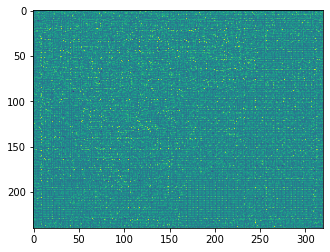

array([[2, 2, 3, ..., 2, 2, 3],
       [2, 2, 2, ..., 3, 2, 3],
       [3, 2, 2, ..., 3, 4, 3],
       ...,
       [2, 3, 2, ..., 2, 3, 2],
       [2, 2, 3, ..., 3, 3, 2],
       [2, 2, 3, ..., 2, 2, 2]])

In [169]:
convert_img_to_labels(img_dcd)

In [171]:
img_dcd.shape

(240, 320)

In [173]:
prediction = convert_hot_to_squeeze_all(img_decoded)

In [261]:
evaluation = Evaluation()

In [262]:
evaluation.get_scores(y_train[:22], prediction)

{'Pixel_accuracy': 0.019025213068181817,
 'Mean_accuracy': 0.04139025215894184,
 'Mean_iou': 0.0024540671864110475}

# GCN 